[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [96]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [ ]:
import os, getpass
from dotenv import load_dotenv

# Load .env
load_dotenv(dotenv_path="../../.env", override=True)

import time
RATE_DELAY_SECS = 60  # throttle between Gemini calls

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# Prefer GOOGLE_API_KEY from .env; fallback to prompt
_set_env("GOOGLE_API_KEY")

In [98]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", google_api_key=os.getenv("GOOGLE_API_KEY"), temperature=0)
llm = llm.with_config({"max_concurrency": 1}) 

E0000 00:00:1761905044.785297 3808943 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [99]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [100]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

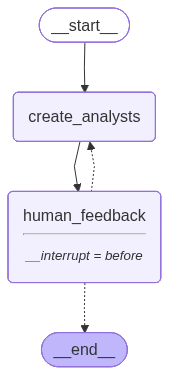

In [101]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [102]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Anya Sharma
Affiliation: Cognitive Systems Institute
Role: Principal AI Architect
Description: Dr. Sharma focuses on the underlying architectural patterns and design principles that enable resilient and sophisticated AI agents. She evaluates how frameworks like LangGraph contribute to building robust, stateful, and fault-tolerant systems capable of complex reasoning and long-running processes. Her primary concern is the structural integrity and advanced capabilities unlocked by such architectures.
--------------------------------------------------
Name: Alex "The Coder" Chen
Affiliation: DevTools & AI Solutions
Role: Senior AI Developer Advocate
Description: Alex is passionate about developer experience and rapid prototyping. He assesses how agent frameworks streamline the development lifecycle, reduce boilerplate, and empower developers to quickly iterate on and deploy AI agents. His focus is on the practical benefits of LangGraph in terms of ease of use, debugging, and acce

In [103]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [104]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from healthtech to add an medicinal perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b640f-5453-6542-8002-203bdb25579e'}}

In [105]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Anya Sharma
Affiliation: Cognitive Systems Institute
Role: Principal AI Architect
Description: Dr. Sharma focuses on the underlying architectural patterns and design principles that enable resilient and sophisticated AI agents. She evaluates how frameworks like LangGraph contribute to building robust, stateful, and fault-tolerant systems capable of complex reasoning and long-running processes. Her primary concern is the structural integrity and advanced capabilities unlocked by such architectures.
--------------------------------------------------
Name: Alex "The Coder" Chen
Affiliation: DevTools & AI Solutions
Role: Senior AI Developer Advocate
Description: Alex is passionate about developer experience and rapid prototyping. He assesses how agent frameworks streamline the development lifecycle, reduce boilerplate, and empower developers to quickly iterate on and deploy AI agents. His focus is on the practical benefits of LangGraph in terms of ease of use, debugging, and acce

In [106]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b640f-a8f4-6344-8004-feb7035fe0d9'}}

In [107]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [108]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [109]:
final_state.next

()

In [110]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Anya Sharma
Affiliation: Global Tech Solutions
Role: Lead AI Architect
Description: Focuses on the technical merits of LangGraph, including its modularity, state management, and ease of debugging, from a developer's standpoint. Concerned with efficient development cycles and robust agent design.
--------------------------------------------------
Name: Mr. David Chen
Affiliation: Enterprise AI Innovations
Role: VP of AI Strategy
Description: Evaluates LangGraph's impact on business outcomes, focusing on ROI, operational efficiency, and the ability to scale complex AI agents across various enterprise applications. Concerned with strategic adoption and competitive advantage.
--------------------------------------------------
Name: Dr. Lena Petrova
Affiliation: MediTech Research Institute
Role: Chief Medical AI Officer
Description: Explores how LangGraph can enhance AI agents in healthcare, such as for diagnostic support, personalized treatment plans, or drug discovery, emphasizi

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [111]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [112]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    time.sleep(RATE_DELAY_SECS)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://docs.langchain.com/oss/python/integrations/document_loaders/web_base)
* Indexed documents e.g., via [RAG](https://docs.langchain.com/oss/python/langchain/retrieval)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [113]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [114]:
# Web search tool
from langchain_tavily import TavilySearch  # updated 1.0

tavily_search = TavilySearch(max_results=3)

In [115]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

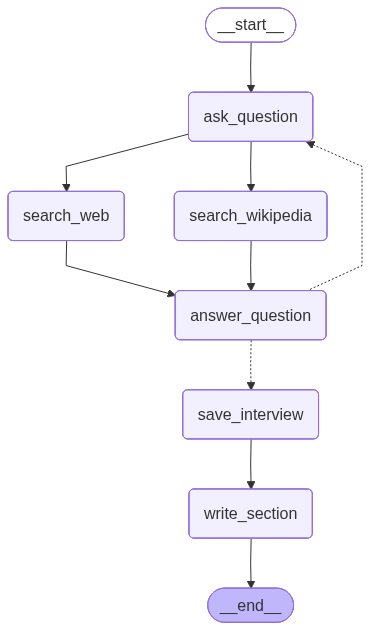

In [116]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    #search_docs = tavily_search.invoke(search_query.search_query) # updated 1.0
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)
    

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [117]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Global Tech Solutions', name='Dr. Anya Sharma', role='Lead AI Architect', description="Focuses on the technical merits of LangGraph, including its modularity, state management, and ease of debugging, from a developer's standpoint. Concerned with efficient development cycles and robust agent design.")

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [118]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 1}, thread)
Markdown(interview['sections'][0])

## LangGraph: Empowering Developers with Modular, Stateful, and Controllable AI Agent Architectures

### Summary
In the evolving landscape of AI agent development, developers frequently encounter challenges related to managing complex interactions, maintaining context, and ensuring robust control flow, particularly in multi-agent systems. The demand for frameworks that offer granular control, facilitate efficient development cycles, and enable the creation of production-ready applications is paramount. LangGraph emerges as a pivotal advancement, fundamentally altering how developers can design and manage AI agent interactions by moving beyond simplistic linear pipelines to a sophisticated, graph-based, stateful orchestration framework.

LangGraph, an open-source framework developed by LangChain, is specifically engineered to build, deploy, and manage intricate generative AI agent workflows [2]. Its core innovation lies in modeling workflows as directed graphs, which inherently supports non-linear, cyclical flows and complex decision-making processes, a significant departure from traditional linear execution models [1]. This graph-based architecture, coupled with its inherent statefulness, provides developers with unprecedented control over how AI agents interact and solve problems [1, 3].

From a developer's standpoint, LangGraph offers compelling technical merits that directly address the need for efficient development and robust agent design:
1.  **Modularity and Flexibility:** The framework's graph structures enable highly flexible workflow design, making it exceptionally suitable for multi-agent systems and complex task automation. This modularity allows developers to construct intricate logic with greater ease and adaptability [1, 3].
2.  **Robust State Management:** A critical feature is its ability to maintain context across interactions, which is essential for reliable and consistent agent behavior. This statefulness is a key enabler for building robust, production-ready agents that can handle real-world scenarios effectively [1, 3].
3.  **Enhanced Control Flow and Debuggability:** LangGraph provides advanced coordination and control flow tools for implementing complex logic. Furthermore, built-in capabilities such as persistence, streaming, and human-in-the-loop support make it ideal for error-tolerant systems. This granular control is invaluable for debugging, refining, and ensuring the reliability of agent behavior in complex applications [1].

Ultimately, LangGraph empowers developers to move beyond basic LLM integrations, enabling the creation of highly customized agents with unique logic, complex multi-actor workflows, and deep human-in-the-loop integration. This flexibility and control are crucial for developing sophisticated agents capable of tackling complex, real-world tasks efficiently and robustly [3].

### Sources
[1] https://www.designveloper.com/blog/what-is-langgraph/
[2] https://www.ibm.com/think/topics/langgraph
[3] https://www.metacto.com/blogs/a-developer-s-guide-to-langgraph-building-stateful-controllable-llm-applications

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [119]:
# Throttled overrides and single-branch interview graph to reduce Gemini 429s
# Rebind nodes with sleep and rebuild graph to only use web search

# Throttled nodes

def search_web(state: InterviewState):
    """Retrieve docs from web search (throttled)."""
    structured_llm = llm.with_structured_output(SearchQuery)
    time.sleep(RATE_DELAY_SECS)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)
    formatted_search_docs = "\n\n---\n\n".join(
        [f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>' for doc in search_docs]
    )
    return {"context": [formatted_search_docs]}


def search_wikipedia(state: InterviewState):
    """Retrieve docs from wikipedia (throttled)."""
    structured_llm = llm.with_structured_output(SearchQuery)
    time.sleep(RATE_DELAY_SECS)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])
    search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [f"<Document>{doc.page_content}</Document>" for doc in search_docs]
    )
    return {"context": [formatted_search_docs]}


def generate_answer(state: InterviewState):
    """Answer a question (throttled)."""
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    time.sleep(RATE_DELAY_SECS)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)
    answer.name = "expert"
    return {"messages": [answer]}


def write_section(state: InterviewState):
    """Write report section (throttled)."""
    context = state["context"]
    analyst = state["analyst"]
    system_message = section_writer_instructions.format(focus=analyst.description)
    time.sleep(RATE_DELAY_SECS)
    section = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"Use this source to write your section: {context}")]
    )
    return {"sections": [section.content]}

# Rebuild a single-branch interview graph (ask_question -> search_web -> answer_question -> ...)
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
# interview_builder.add_node("search_wikipedia", search_wikipedia)  # disabled to reduce concurrency
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
# interview_builder.add_edge("ask_question", "search_wikipedia")  # disabled
interview_builder.add_edge("search_web", "answer_question")
# interview_builder.add_edge("search_wikipedia", "answer_question")  # disabled
interview_builder.add_conditional_edges("answer_question", route_messages, ["ask_question", "save_interview"])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")


In [120]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

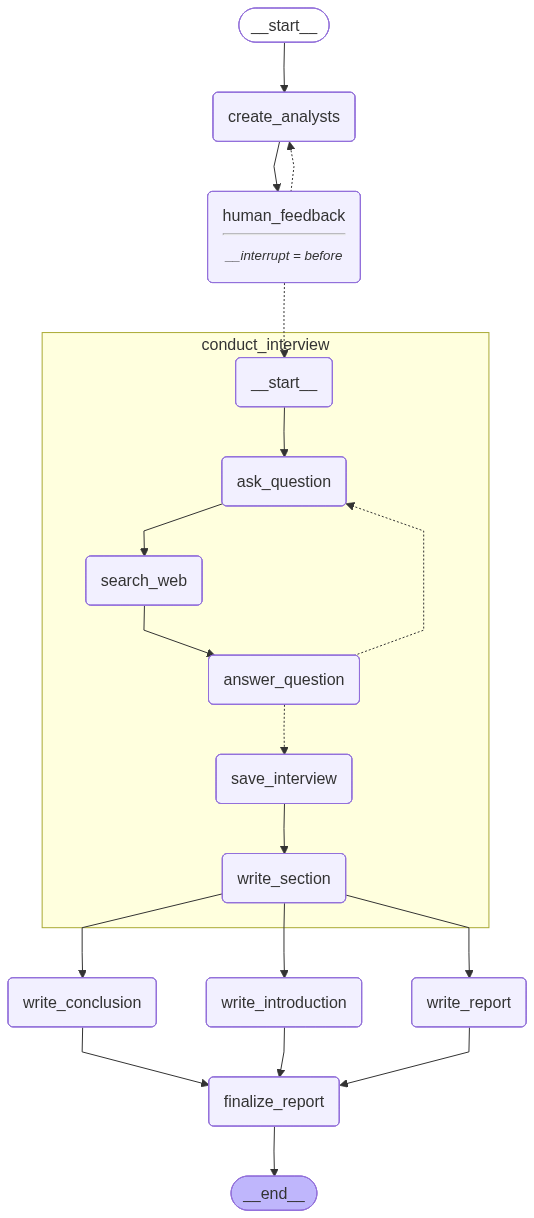

In [121]:
from langgraph.types import Send # updated in 1.0
def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [122]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting human robot collaboration in manufacturing"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Lena Hansen
Affiliation: Global Institute for Industrial Automation
Role: Manufacturing Operations Strategist
Description: Focuses on quantifying the operational benefits of human-robot collaboration (HRC), including throughput, cycle time reduction, and overall equipment effectiveness (OEE). Concerned with optimizing production lines and maximizing ROI through advanced automation.
--------------------------------------------------
Name: Dr. Alex Sharma
Affiliation: Future of Work Research Foundation
Role: Occupational Health and Safety Expert
Description: Specializes in the human factors of manufacturing. Investigates how HRC mitigates workplace hazards, reduces repetitive strain injuries, and creates a safer, more ergonomic environment for human workers. Advocates for human-centric automation design.
--------------------------------------------------
Name: Professor Mei Lin
Affiliation: University of Applied Robotics and Materials Science
Role: Advanced Manufacturing Qualit

In [123]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b6413-4ffe-6a9c-8002-3dbedaa21954'}}

In [124]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Lena Hansen
Affiliation: Global Institute for Industrial Automation
Role: Manufacturing Operations Strategist
Description: Focuses on quantifying the operational benefits of human-robot collaboration (HRC), including throughput, cycle time reduction, and overall equipment effectiveness (OEE). Concerned with optimizing production lines and maximizing ROI through advanced automation.
--------------------------------------------------
Name: Dr. Alex Sharma
Affiliation: Future of Work Research Foundation
Role: Occupational Health and Safety Expert
Description: Specializes in the human factors of manufacturing. Investigates how HRC mitigates workplace hazards, reduces repetitive strain injuries, and creates a safer, more ergonomic environment for human workers. Advocates for human-centric automation design.
--------------------------------------------------
Name: Professor Mei Lin
Affiliation: University of Applied Robotics and Materials Science
Role: Advanced Manufacturing Qualit

In [125]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b6413-996b-6676-8004-df8369d19c51'}}

In [126]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [127]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Unlocking the Future of Manufacturing: The Power of Human-Robot Collaboration

## Introduction
The manufacturing landscape is undergoing a profound transformation, driven by the synergistic adoption of Human-Robot Collaboration (HRC). This report explores how HRC moves beyond traditional automation, delivering substantial ROI through enhanced productivity, reduced cycle times, and unparalleled operational flexibility, particularly in high-mix environments. We delve into the evolving role of the human workforce, demonstrating how HRC fosters job enrichment and necessitates strategic reskilling, all while prioritizing a safe and efficient workplace. Finally, we examine the revolutionary impact of Generative AI, which is empowering robots with genuine intelligence and adaptability, enabling sophisticated human-AI partnerships and ushering in a new era of smart, resilient, and human-centric manufacturing.

---



Human-robot collaboration (HRC) is fundamentally reshaping the manufacturing landscape, moving beyond traditional automation to create more efficient, flexible, and human-centric production environments. This synergistic approach allows humans and robots to work harmoniously, leading to substantial tangible benefits that directly enhance production output, reduce cycle times, and drive overall operational excellence [1, 2]. HRC makes manufacturing faster, more cost-effective, and safer by strategically leveraging human workers for tasks requiring flexibility and critical thinking, while robots handle repetitive, strength-intensive, or high-speed operations [3].

A key differentiator of HRC is its inherent flexibility, enabling manufacturers to easily adapt to shifting market demands and introduce new products and processes without onerous retooling. This significantly improves factory economics and allows for rapid changeovers, particularly beneficial for high-mix, low-volume production, while maintaining consistent quality without the extensive overhead of traditional industrial robotics [3, 4]. Safety standards are integral to HRC systems, greatly reducing risks and making close collaboration between human operators and robots feasible in industrial settings such as assembly lines [1]. Advanced safety features, including sensors and soft-touch technology, allow cobots to detect and respond to human presence in real-time, further enhancing workplace security [1, 10].

Beyond operational improvements, HRC is poised to foster job enrichment rather than displacement, positioning itself as a cornerstone of the future "Industry 5.0" – one that is resilient, sustainable, and human-centred [7, 8, 9]. By allowing robots to handle tasks requiring strength and speed, human workers can focus on roles demanding flexibility, critical thinking, and problem-solving, thereby elevating the quality and complexity of human work [3]. This challenges the common apprehension that automation inevitably leads to job losses, instead highlighting a path towards more engaging and value-added human roles. The journey towards widespread HRC, however, demands continuous technological developments alongside significant investment in workforce reskilling and upskilling. Targeted training programs, including robotics certifications and advanced collaborative robotics training, along with practical experience, are crucial for career development in this evolving field [7, 10].

The integration of Artificial Intelligence (AI) further elevates HRC to new levels of efficiency and seamless integration. AI utilizes real-time data to dynamically adjust production, prevent failures, and improve quality, leading to reduced downtime, minimized waste, and significantly faster operations [6]. AI applications, such as predictive maintenance, computer vision for precise quality inspection, and optimized scheduling, augment worker capabilities and ensure smoother, more flexible automation [6]. This AI-driven simplicity, featuring advanced demonstration learning and real-time adaptation, ensures that HRC systems integrate smoothly into existing production lines, maximizing ROI through enhanced operational control and adaptability [6].

The landscape of manufacturing and collaborative production systems is undergoing a profound transformation, driven by the integration of generative artificial intelligence (AI). This paradigm shift moves beyond traditional automation, where robots merely follow pre-programmed instructions, towards a future where AI-powered systems exhibit genuine intelligence and adaptability [11, 13]. Generative AI is endowing robots with a "brain that actually thinks," enabling them to move beyond blind obedience to become intuitive, adaptive, and intelligent collaborative partners [13]. This emphasis on human-AI collaboration fundamentally changes how things are made, fostering a partnership between people and AI, rather than just robots performing tasks [15]. This collaborative intelligence is further amplified by the development of Embodied Multi-Agent Systems (EMAS), which integrate physical robots and autonomous vehicles with multi-agent systems to create decentralized, collaborative approaches capable of handling complex tasks with remarkable efficiency [12]. These systems leverage Foundation Model (FM)-based generative agents to facilitate dynamic collaboration and emergent intelligence, focusing on critical technologies such as perception, planning, communication, and feedback mechanisms [12]. Large Language Models (LLMs) are central to this advancement, enabling sophisticated robot task planning, often referred to as "Smart-llm" [11, 12]. The benefits of integrating generative AI into collaborative robotics are extensive, significantly enhancing efficiency and safety in collaborative robot operations, while also fostering innovation across manufacturing processes [14]. Furthermore, generative AI facilitates real-time data analysis, leading to improved decision-making on the shop floor and enabling the rapid identification of potential risks, thereby optimizing overall operational resilience [16]. The growing market for collaborative robots, with applications spanning automotive assembly, electronics, and packaging, underscores their widespread adoption and profound impact on manufacturing efficiency and profitability [5]. This convergence of embodied AI, multi-agent systems, and generative models is pushing the boundaries of what's possible in manufacturing, creating more intuitive and intelligent collaborative robot systems.


---

## Conclusion

Human-Robot Collaboration (HRC) is fundamentally reshaping manufacturing, moving beyond traditional automation to unlock significant ROI through enhanced productivity, faster cycle times, and superior safety. This report has detailed how HRC leverages human flexibility and robotic precision, adapting seamlessly to market demands and optimizing production. We explored the critical evolution of the workforce, emphasizing job enrichment and the necessity of continuous skill development for a human-centric Industry 5.0. Crucially, the integration of generative AI is now propelling HRC into an era of intelligent, adaptive systems, enabling robots to "think" and collaborate with unprecedented sophistication. Embracing these advancements is key to future manufacturing success.

## Sources
[1] https://pmc.ncbi.nlm.nih.gov/articles/PMC10304173/
[2] https://www.expresscomputer.in/guest-blogs/how-human-robot-collaboration-will-affect-the-manufacturing-industry/108432/
[3] https://www.weforum.org/stories/2020/08/here-s-how-robots-can-help-us-confront-covid/
[4] https://meltonmachine.com/blog/how-collaborative-robotics-is-boosting-efficiency-in-high-mix-low-volume-production/
[5] https://www.idtechex.com/en/research-report/collaborative-robots-2025/1046
[6] https://standardbots.com/blog/ai-manufacturing
[7] https://www.sciencedirect.com/science/article/pii/S004016252500280X
[8] https://falconediting.com/en/blog/exploring-human-robot-collaboration-in-manufacturing/
[9] https://www.unboxindustry.com/blog/87-creating-synergy-between-humans-and-robots-in-manufacturing?srsltid=AfmBOooA0DUs2RyZMxDBP2ws_N31j70J96j4x0vQmAgcfxazcKcvW6_-
[10] https://www.roboticscareer.org/news-and-events/news/84000
[11] https://www.sciencedirect.com/science/article/pii/S2212827124007510
[12] https://arxiv.org/html/2502.11518v1
[13] https://standardbots.com/blog/generative-ai-in-robotics
[14] https://www.emerald.com/jmtm/article/35/9/94/1228980/Generative-artificial-intelligence-in
[15] https://www.researchgate.net/publication/394810049_Human-AI_Collaboration_in_Manufacturing_Unlocking_New_Possibilities_with_Generative_AI
[16] https://www.mdpi.com/2227-9717/13/4/1174

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r